# Image processing 1: Edge detection using approximated adder

Author: Vladislav Válek

In [1]:
# Loading required packages packages
from skimage import io, img_as_float, img_as_ubyte
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

## Adders

### Exact Adder Function

Outpus also the energy consumption for each result.

In [2]:
def ExactAdder(a, b, c):
    if a==0 and b==0 and c==0:
        s=0
        c_out=0
        energy_consumption = 4971
    elif a==0 and b==0 and c==1:
        s=1
        c_out=0
        energy_consumption = 123 
    elif a==0 and b==1 and c==0:
        s=1
        c_out=0
        energy_consumption = 3021 
    elif a==0 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 8293 
    elif a==1 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 2175 
    elif a==1 and b==0 and c==1:
        s=0
        c_out=1
        energy_consumption = 2397 
    elif a==1 and b==1 and c==0:
        s=0
        c_out=1
        energy_consumption = 1092 
    elif a==1 and b==1 and c==1:
        s=1
        c_out=1
        energy_consumption = 13
    return s, c_out, energy_consumption

### Approximate Adder Function

The output result deviates from the exact solution.

Failure Cases:
- Input (0, 0, 0): Incorrect sum (s) = 1 Correct carry-out (c_out) = 0
- Input (1, 1, 1): Incorrect sum (s) = 0 Correct carry-out (c_out) = 1


In [3]:
def ApproxAdder(a, b, c):
    if a==0 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 984
    elif a==0 and b==0 and c==1:
        s=1
        c_out=0
        energy_consumption = 1098
    elif a==0 and b==1 and c==0:
        s=1
        c_out=0
        energy_consumption = 831 
    elif a==0 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 239 
    elif a==1 and b==0 and c==0:
        s=1
        c_out=0
        energy_consumption = 492 
    elif a==1 and b==0 and c==1:
        s=0
        c_out=1
        energy_consumption = 319 
    elif a==1 and b==1 and c==0:
        s=0
        c_out=1
        energy_consumption = 598 
    elif a==1 and b==1 and c==1:
        s=0
        c_out=1
        energy_consumption = 658 
    return s, c_out, energy_consumption


### N-bit Adder Function

The MyNbitAdder function is designed to perform N-bit addition. Approximation takes place from lower bits to higher ones and the amount of approximated bits can be configured with 'approx_until' parameter. THe adder can also work with negative numbers as inputs. The 'n' parameter defines the bit length of the internally represented binary numbers. 

In [4]:
def MyNbitAdder(a,b, n = 12, approx_until = 0):
    
    # Ensure that a and b are within range of signed integer
    a = (a + 2**(n - 1)) % 2**n - 2**(n - 1)
    b = (b + 2**(n - 1)) % 2**n - 2**(n - 1)

    #convert to binary and cut off the first two indices (they dont belong to the number but indicate that it is binary)
    # Eventually fill with 0 to the full length of n
    a_bin = bin(a & ((1 << n) - 1))[2:].zfill(n)
    b_bin = bin(b & ((1 << n) - 1))[2:].zfill(n)

    #reverse order bits for the adder
    rev_a , rev_b = list(a_bin[::-1]), list(b_bin[::-1])
    
    carry_over   = 0
    total_sum    = 0
    total_energy = 0
    
    #we want to do a bitwise addition
    for index, (bit1, bit2) in enumerate( zip(rev_a, rev_b) ):

        if index < approx_until:
            #use approx_adder
            sum_element, carry_over, energy = ApproxAdder(int(bit1), int(bit2), int(carry_over) ) 
        else:
            #use exact_adder
            sum_element, carry_over, energy = ExactAdder(int(bit1), int(bit2), int(carry_over) )
            
        total_sum += pow(2,index)*sum_element
        total_energy += energy

    if total_sum >= 2**(n-1):
        total_sum -= 2**n 

    return total_sum, total_energy

test_cases = [
    (0, 0),     # 0 + 0 = 0
    (0, -1),     # 0 + -1 = -1
    (-1, 0),     # -1 + 0 = 0
    (5, 7),     # 5 + 7 = 12
    (-1, -1),   # -1 + -1 = -2 (overflow)
    (8, -3),    # 8 + (-3) = 5
    (-8, 3),    # -8 + 3 = -5
    (-8, -3),   # -8 + (-3) = -11
    (15, 1),    # 15 + 1 = -16 (overflow)
]

for a, b in test_cases:
    result,_ = MyNbitAdder(a, b)
    print(f"MyNbitAdder({a}, {b}) = {result}, test: {result == a+b}")

#MyNbitAdder(4,2)
MyNbitAdder(-1,-1)


MyNbitAdder(0, 0) = 0, test: True
MyNbitAdder(0, -1) = -1, test: True
MyNbitAdder(-1, 0) = -1, test: True
MyNbitAdder(5, 7) = 12, test: True
MyNbitAdder(-1, -1) = -2, test: True
MyNbitAdder(8, -3) = 5, test: True
MyNbitAdder(-8, 3) = -5, test: True
MyNbitAdder(-8, -3) = -11, test: True
MyNbitAdder(15, 1) = 16, test: True


(-2, 1235)

## Filters for image processing

1) Low Pass Filter

    - f1: Low pass average filter

    These filters are designed for tasks such as removing noise from images or smoothing/blurring images. The key characteristic is that the sum of all the kernel elements should be one.

2) Filters for edge detection 

    - sobel_vertical   : Sobel vertical edge filter
    - sobel_horizontal : Sobel horizontal edge filter

    These filters are a form of high-pass filters. The sum of all elements within each of them should be 0.

In [7]:
f1 = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]
f1 = 1/9 *np.array(f1)

sobel_vertical = [
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
]
sobel_vertical = np.array(sobel_vertical)

sobel_horizontal = [
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]
sobel_horizontal = np.array(sobel_horizontal)


## Derived adder function
These are designed for specific applications that use MyNbiAdder internally.

### Image Adder Function
The ImageAdder function takes two images (f and g) and performs an pixel wise addition of them.

In [6]:
# Function that adds two images
def ImageAdder(f,g, approx_until = 0):
    
    # convert pixel values of both images to integers
    f=np.array(f).astype(int)
    g=np.array(g).astype(int)
    
    res = np.zeros(f.shape)
    total_energy = 0
    
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            
            #we will use a custom adding function
            res[i, j], energy = MyNbitAdder(f[i,j],g[i,j], approx_until = approx_until)
            total_energy += energy
    
    return res, total_energy

f = np.eye(3)
g = np.eye(3)
ImageAdder(f,g)

(array([[2., 0., 0.],
        [0., 2., 0.],
        [0., 0., 2.]]),
 510687)

### Reduction sum
This function takes a 1D or 2D array of number and adds all its elements together. It uses MyNbitAdder for addition. This functionality as also known as folding.

In [8]:
def SumReduction(n, approx_until = 0):

    shap = n.shape
    n = np.array(n).astype(int)
    total_energy = 0

    if (len(shap) == 1):
        res = n[0]

        for i in range(1,shap[0]):
            res,energy = MyNbitAdder(res,n[i], approx_until = approx_until)
            total_energy += energy

    elif (len(shap) == 2):
        res = n[0,0]

        for i in range(shap[0]):
            for j in range(shap[1]):

                # There is no reason to calculating this because we are reducing a matrix so 
                # first element is only saved and the algorithm goes on.
                if (i == 0 and j == 0): continue

                res,energy = MyNbitAdder(res,n[i,j], approx_until = approx_until)
                total_energy += energy
    
    return res, total_energy

SumReduction(sobel_horizontal)

(0, 240501)

## Import sample image

A sample image is a very sympathetic man that uses its old camera to take photos.

(277, 270, 3)
(277, 270)
[[254. 249. 255. ... 253. 241. 253.]
 [247. 255. 255. ... 255. 255. 254.]
 [250. 255. 231. ... 243. 255. 255.]
 ...
 [251. 255. 201. ... 253. 255. 255.]
 [245. 255. 247. ... 255. 255. 252.]
 [255. 253. 255. ... 254. 242. 255.]]


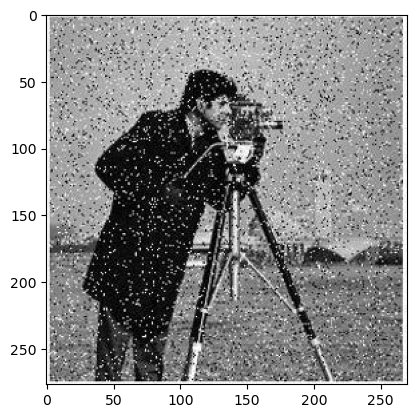

In [9]:
# Your code here
sample_image = io.imread("man.jpeg")
filter_kernel = f1
print(sample_image.shape)

R_1 = sample_image[:, :, 0] 
G_1 = sample_image[:, :, 1]
B_1 = sample_image[:, :, 2]

#formula for converting colour(RGB) to Gray Image scale Image
Y_sample = (0.299 * np.array(R_1)) + (0.587 * np.array(G_1)) + (0.114 * np.array(B_1)) 

plt.imshow(Y_sample , cmap = "gray")
print(Y_sample.shape)
print(Y_sample)

## Function "LaConvolution"

This function performs a standard convolution on an image the same way as signal.convolve2d with mode set to 'same'. This outputs the resulting image with the same size as the input image.

In [10]:
def LaConvolution(image, kernel, approx_until = 0):
    x,y = image.shape
    k,l = kernel.shape
    # print(x,y)

    pad_image = np.pad(image, ((k // 2, k // 2),(l // 2, l // 2)), mode = "constant")
    xp, yp = pad_image.shape
    # print(pad_image.shape)
    # print(pad_image)

    flipped_kernel = np.flipud(np.fliplr(kernel))

    result = np.zeros_like(image)
    total_energy = 0

    for i in range(x):
        for j in range(y):
            # print(i,",", j)
            region = pad_image[i:i + k, j:j + l]
            result[i, j], energy = SumReduction(region * flipped_kernel, approx_until)

            total_energy += energy

    return result, energy

kern2 = [
    [0,1],
    [1,1]
]

kern3 = [
    [-1,2,1],
    [0,1,0],
    [1,2,-1]
]

kern4 = [
    [-1, 0, 1, 2],
    [ 0, 1, 2, 3],
    [ 1, 2, 3, 2],
    [ 2, 3, 2,-1]
]

random_matrix = [
    [12, 79, 27,  2, 45,  4, 41, 62],
    [ 0, 93,  4, 39, 24, 13, 76, 73],
    [35, 50, 36, 81,  3, 15, 50, 95],
    [80, 78, 61, 95,  5, 79, 12, 56],
    [95, 74, 65, 16, 89, 73, 13, 10],
    [51, 35, 34,  6, 25, 40,  3, 90],
    [84, 92, 32, 48, 17, 93,  5, 14],
    [52, 54, 32, 68, 79, 91, 68, 71]
]

# Tests:
exact_convol = signal.convolve2d(random_matrix, kern2, mode = "same")
appr_convol,_ = LaConvolution(np.array(random_matrix),np.array(kern2)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("Convolution with kern2 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("SUCCESS: Convolution with kern2!")

exact_convol = signal.convolve2d(random_matrix, kern3, mode = "same")
appr_convol,_ = LaConvolution(np.array(random_matrix),np.array(kern3)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("Convolution with kern3 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("SUCCESS: Convolution with kern3!")

exact_convol = signal.convolve2d(random_matrix, kern4, mode = "same")
appr_convol,_ = LaConvolution(np.array(random_matrix),np.array(kern4)) 

if (not np.array_equal(exact_convol, appr_convol)):
    print("Convolution with kern4 unsuccesful!")
    print("Exact convolution:")
    print(exact_convol.shape)
    print(exact_convol)
    print("My convolution:")
    print(appr_convol.shape)
    print(appr_convol)
else:
    print("SUCCESS: Convolution with kern4!")

SUCCESS: Convolution with kern2!
SUCCESS: Convolution with kern3!
SUCCESS: Convolution with kern4!


## Using filters

Some examples of using specified filters on our imported image.

357837


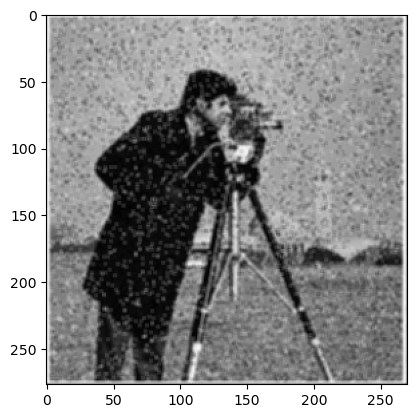

In [11]:
f1_img, enrg = LaConvolution(Y_sample,f1)
print(enrg)
plt.imshow(f1_img, cmap = "gray")

317581


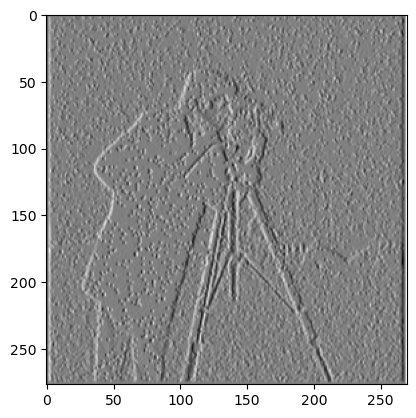

In [12]:
horiz_edges, enrg = LaConvolution(Y_sample,sobel_horizontal)
print(enrg)
plt.imshow(horiz_edges, cmap = "gray")

358019


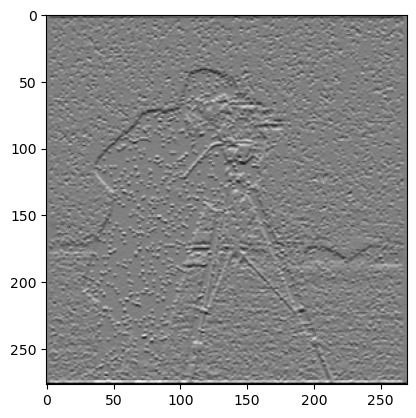

In [14]:
vert_edges, enrg = LaConvolution(Y_sample,sobel_vertical)
print(enrg)
plt.imshow(vert_edges, cmap = "gray")

### Concluding analysis

This measures MSE, SSIM and PSNR when image processed by the LaConvolution function and by signal.convolve2d. The iteration over multiple approximation levels takes place as even more and more bits are approximated thus also the LaConvolution function's result gets more erroneous.

In [19]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

exact_convolution_result = signal.convolve2d(Y_sample, sobel_horizontal, mode = "same")

# Your code here
for i in range(8):
    print("Number of approximated bits on addition: ", i)
    approx_convolution_result,_ = LaConvolution(Y_sample, sobel_horizontal, i)

    data_range = exact_convolution_result.max() - exact_convolution_result.min()
   
    # Compare results and calculate error/similarity
    error = mse(exact_convolution_result, approx_convolution_result)
    print("    MSE = {}".format(error))
    similarity = ssim(exact_convolution_result, approx_convolution_result, data_range=data_range)
    print("    SSIM = {}".format(similarity))
    peak_snr = psnr(exact_convolution_result, approx_convolution_result, data_range=data_range)
    print("    PSNR = {}".format(peak_snr))

Number of approximated bits on addition:  0
    MSE = 1.0499532022997324
    SSIM = 0.9999544357541231
    PSNR = 65.98090392387495
Number of approximated bits on addition:  1
    MSE = 4.0713196951463715
    SSIM = 0.9973434978245925
    PSNR = 60.09525128717392
Number of approximated bits on addition:  2
    MSE = 17.193876186655952
    SSIM = 0.9874186663243821
    PSNR = 53.83886539798968
Number of approximated bits on addition:  3
    MSE = 58.71621874582162
    SSIM = 0.9686621005471773
    PSNR = 48.505022550878635
Number of approximated bits on addition:  4
    MSE = 195.79957213531222
    SSIM = 0.9370023009701431
    PSNR = 43.27448596411624
Number of approximated bits on addition:  5
    MSE = 683.2752239604225
    SSIM = 0.8764092832405447
    PSNR = 37.846646616665815
Number of approximated bits on addition:  6
    MSE = 2446.7811472121944
    SSIM = 0.7652870430382724
    PSNR = 32.30665209312307
Number of approximated bits on addition:  7
    MSE = 8913.072790480011
    